In [51]:
import sys
import os
sys.path.append("../")
import time

from src.datasets.SNLIData import SNLIData

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.metrics import recall_score, make_scorer

import torch
from torch import nn

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

from src.models.NeuralNetwork import NeuralNetworkClassifier

from src.plots.CrossValidationFolds import CrossValidationFolds
from src.plots.ValidationCurve import ValidationCurve as ValidationCurvePlot
from src.plots.Histogram import Histogram
from src.plots.LearningCurve import LearningCurve as LearningCurvePlot
from src.plots.ClassificationReport import ClassificationReport
from src.plots.ConfusionMatrix import ConfusionMatrix
from src.plots.ScatterPlot import ScatterPlot
from src.plots.CompareFitScoreTimes import CompareFitScoreTimes
from src.plots.BoostingIterations import BoostingIterations as BoostingIterationsPlot
from src.plots.LearningEpochsCurve import LearningEpochsCurve as LearningEpochsCurvePlot

from src.experiments.CrossValidation import CrossValidation
from src.experiments.ValidationCurve import ValidationCurve
from src.experiments.ModelEvaluation import ModelEvaluation
from src.experiments.LearningCurve import LearningCurve
from src.experiments.BoostingIterations import BoostingIterations
from src.experiments.LearningCurveEpochs import LearningCurveEpochs


%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
plt.style.use('seaborn')

In [3]:
random_state = 279
snli_data = snli_data = SNLIData(random_state=random_state)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9824/9824 [00:00<00:00, 11519.83it/s]


In [4]:
X_train, X_val, y_train, y_val = train_test_split(
    snli_data.X_train, 
    snli_data.y_train, 
    train_size=100000, 
    test_size=100000, 
    random_state=random_state
)

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

X_val = X_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

In [5]:
def recall_entailment_contradiction(y_true, y_pred):
    return recall_score(y_true, y_pred, labels=[0, 1], average='macro')

recall_scorer = make_scorer(recall_entailment_contradiction)

In [76]:
X_train_samp, _, y_train_samp, _ = train_test_split(X_train, y_train, train_size=10000, random_state=random_state)
X_train_samp = X_train_samp.reset_index(drop=True)
y_train_samp = y_train_samp.reset_index(drop=True)

## Data Exploration

In [6]:
snli_data.classes

['contradiction', 'entailment', 'neutral']

In [7]:
class_balance_plot = Histogram(
    y_train, 
    labels=y_train, 
    xticks=snli_data.classes,
    title="Target Class Balance"
)

In [8]:
ft81_hist_plot = Histogram(
    X_train['feature_81'],
    feature_name='feature_81',
    labels=y_train, 
    bins=100,
    label_names=snli_data.classes,
    legend=True
)

In [9]:
ft9_hist_plot = Histogram(
    X_train['feature_9'],
    feature_name='feature_9',
    labels=y_train, 
    bins=100,
    label_names=snli_data.classes,
    legend=True
)

In [10]:
contr_entail_y_train_idx = y_train[(y_train == 0) | (y_train == 1)].index
contra_entail_instances = X_train.iloc[contr_entail_y_train_idx].copy()
contra_entail_instances['label'] = y_train[contr_entail_y_train_idx].copy()

compare_ft81_to_ft9_scatter = ScatterPlot(
    contra_entail_instances, 
    'feature_9', 'feature_81', 'label', label_names=['contradiction', 'entailment'])

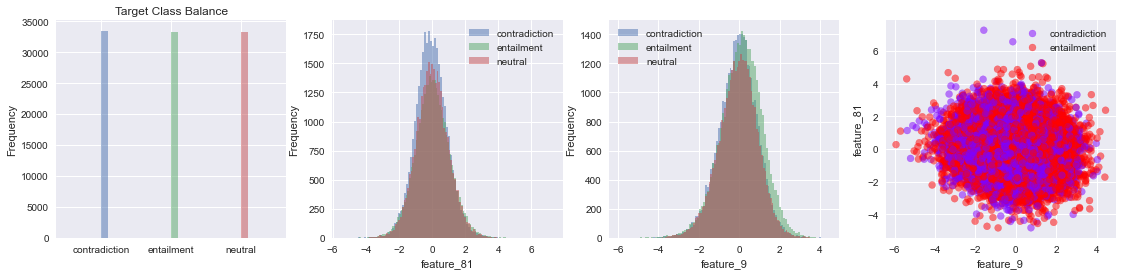

In [11]:
data_exp_fig, axs = plt.subplots(1, 4, figsize=(19, 4))
_, ax = class_balance_plot.plot(ax=axs[0])
_, ax = ft81_hist_plot.plot(ax=axs[1])
_, ax = ft9_hist_plot.plot(ax=axs[2])
_, ax = compare_ft81_to_ft9_scatter.plot(ax=axs[3])

In [12]:
data_exp_fig.savefig(
    "../out/SNLI/Data Exploration - Report.png",
    bbox_inches='tight',
    dpi=800
)

## Decision Tree

In [13]:
untuned_dt_clf = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=20,
    min_samples_leaf=1,
    min_samples_split=2
)

tuned_dt_clf = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=7,
    min_samples_leaf=1,
    min_samples_split=1925
)

dt_untuned_learning_curve = LearningCurve(untuned_dt_clf, scoring=recall_scorer)
dt_untuned_learning_curve.run(X_train, y_train)
dt_untuned_learning_curve_plot = LearningCurvePlot(experiment=dt_untuned_learning_curve)

dt_tuned_learning_curve = LearningCurve(tuned_dt_clf, scoring=recall_scorer)
dt_tuned_learning_curve.run(X_train, y_train)
dt_tuned_learning_curve_plot = LearningCurvePlot(experiment=dt_tuned_learning_curve)

dt_tuned_cv = CrossValidation(tuned_dt_clf, scoring=recall_scorer)
dt_tuned_cv.run(X_train, y_train)
dt_tuned_cv_folds = CrossValidationFolds(experiment=dt_tuned_cv)

[learning_curve] Training set sizes: [ 8000 26000 44000 62000 80000]


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of  25 | elapsed:   10.1s remaining:  1.9min
[Parallel(n_jobs=3)]: Done   8 out of  25 | elapsed:   44.8s remaining:  1.6min
[Parallel(n_jobs=3)]: Done  14 out of  25 | elapsed:  1.3min remaining:  1.0min
[Parallel(n_jobs=3)]: Done  20 out of  25 | elapsed:  1.9min remaining:   27.8s
[Parallel(n_jobs=3)]: Done  25 out of  25 | elapsed:  2.6min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


[learning_curve] Training set sizes: [ 8000 26000 44000 62000 80000]


[Parallel(n_jobs=3)]: Done   2 out of  25 | elapsed:    3.3s remaining:   38.3s
[Parallel(n_jobs=3)]: Done   8 out of  25 | elapsed:   16.8s remaining:   35.7s
[Parallel(n_jobs=3)]: Done  14 out of  25 | elapsed:   29.7s remaining:   23.4s
[Parallel(n_jobs=3)]: Done  20 out of  25 | elapsed:   43.3s remaining:   10.8s
[Parallel(n_jobs=3)]: Done  25 out of  25 | elapsed:  1.0min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   5 | elapsed:   13.4s remaining:   20.0s
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:   25.5s finished


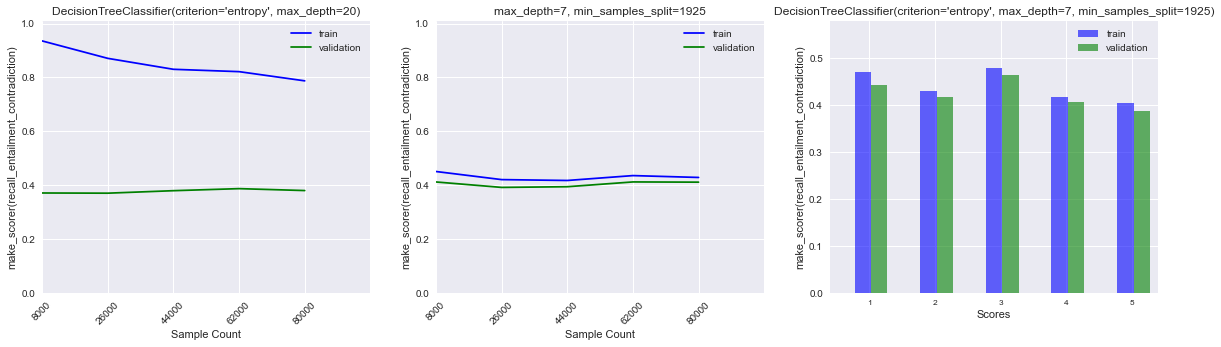

In [15]:
dt_train_curv_fig, axs = plt.subplots(1, 3, figsize=(20, 5))
_, ax = dt_untuned_learning_curve_plot.plot(ax=axs[0], ymin=0.0, ymax=1.01)
_, ax = dt_tuned_learning_curve_plot.plot(ax=axs[1], ymin=0.0, ymax=1.01, title="max_depth=7, min_samples_split=1925")
_, ax = dt_tuned_cv_folds.plot(ax=axs[2])

In [16]:
dt_train_curv_fig.savefig(
    "../out/SNLI/DecisionTree/LearningCurves - Report.png",
    bbox_inches='tight',
    dpi=800
)

In [17]:
val_curv = ValidationCurve(
    DecisionTreeClassifier(max_depth=None, min_samples_split=2, min_samples_leaf=1, class_weight='balanced'),
    'min_samples_leaf',
   np.arange(1, 3500, 500),
    scoring=recall_scorer
)
val_curv.run(X_train, y_train)
min_samples_leaf_plot = ValidationCurvePlot(experiment=val_curv)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of  35 | elapsed:   19.3s remaining:  2.5min
[Parallel(n_jobs=3)]: Done  12 out of  35 | elapsed:   46.9s remaining:  1.5min
[Parallel(n_jobs=3)]: Done  20 out of  35 | elapsed:  1.3min remaining:   58.3s
[Parallel(n_jobs=3)]: Done  28 out of  35 | elapsed:  1.8min remaining:   26.5s
[Parallel(n_jobs=3)]: Done  35 out of  35 | elapsed:  2.2min finished


In [18]:
val_curv = ValidationCurve(
    DecisionTreeClassifier(max_depth=None, min_samples_split=2, min_samples_leaf=1, class_weight='balanced'),
    'max_depth',
    np.arange(2, 15, 2),
    scoring=recall_scorer
)
val_curv.run(X_train, y_train)
max_depth_plot = ValidationCurvePlot(experiment=val_curv)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of  35 | elapsed:   13.1s remaining:  1.7min
[Parallel(n_jobs=3)]: Done  12 out of  35 | elapsed:   41.4s remaining:  1.3min
[Parallel(n_jobs=3)]: Done  20 out of  35 | elapsed:  1.1min remaining:   49.7s
[Parallel(n_jobs=3)]: Done  28 out of  35 | elapsed:  1.5min remaining:   22.1s
[Parallel(n_jobs=3)]: Done  35 out of  35 | elapsed:  2.0min finished


In [19]:
val_curv = ValidationCurve(
    DecisionTreeClassifier(max_depth=None, min_samples_split=2, min_samples_leaf=1, class_weight='balanced'),
    'min_samples_split',
    np.arange(2, 3500, 500),
    scoring=recall_scorer
)
val_curv.run(X_train, y_train)
min_samples_split_plot = ValidationCurvePlot(experiment=val_curv)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of  35 | elapsed:   24.8s remaining:  3.2min
[Parallel(n_jobs=3)]: Done  12 out of  35 | elapsed:   59.5s remaining:  1.9min
[Parallel(n_jobs=3)]: Done  20 out of  35 | elapsed:  1.6min remaining:  1.2min
[Parallel(n_jobs=3)]: Done  28 out of  35 | elapsed:  2.2min remaining:   33.1s
[Parallel(n_jobs=3)]: Done  35 out of  35 | elapsed:  2.7min finished


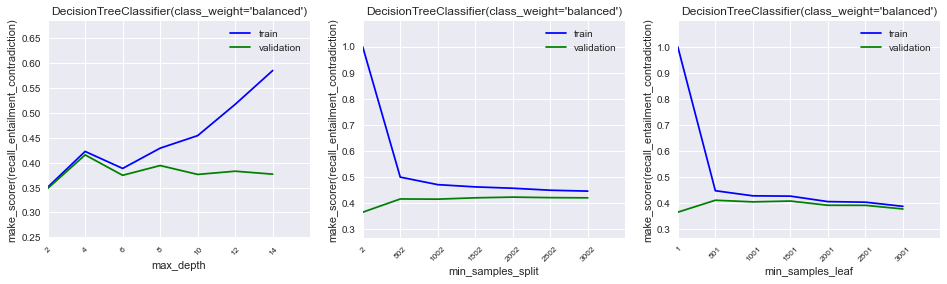

In [20]:
validation_fig, axs = plt.subplots(1, 3, figsize=(16, 4))
_, ax = max_depth_plot.plot(ax=axs[0])
_, ax = min_samples_split_plot.plot(ax=axs[1])
_, ax = min_samples_leaf_plot.plot(ax=axs[2])

In [21]:
validation_fig.savefig(
    "../out/SNLI/DecisionTree/ValidationCurves - Report.png",  
    bbox_inches='tight',
    dpi=800
)

In [23]:
tuned_model_eval = ModelEvaluation(tuned_dt_clf)
tuned_model_eval.run(X_train, y_train, snli_data.X_test, snli_data.y_test)
print(tuned_model_eval.model)
print(ClassificationReport(experiment=tuned_model_eval).plot())

DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_split=1925)
              precision    recall  f1-score   support

           0       0.38      0.37      0.38      3237
           1       0.43      0.42      0.43      3368
           2       0.38      0.39      0.38      3219

    accuracy                           0.40      9824
   macro avg       0.40      0.40      0.40      9824
weighted avg       0.40      0.40      0.40      9824



## Support Vector Machine

In [27]:
X_train_sub, _, y_train_sub, _ = train_test_split(X_train, y_train, train_size=20000, random_state=random_state)

In [24]:
untuned_svm_clf = LinearSVC(
    C=1.0, max_iter=1000, penalty='l2', dual=False, verbose=0
)

# SVC(C=0.15, gamma=0.01, kernel='rbf')
tuned_svm_clf = SVC(C=0.05, gamma=0.01, kernel='rbf')

In [87]:
svm_untuned_learning_curve = LearningCurve( 
    untuned_svm_clf, 
    scoring=recall_scorer, 
    n_splits=3
)
svm_untuned_learning_curve.run(X_train, y_train)

[learning_curve] Training set sizes: [ 6666 21666 36666 51666 66666]


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of  15 | elapsed:    5.0s remaining:   13.6s


[CV] END ..n_estimators=100;, score=(train=0.662, test=0.444) total time=  26.6s
[CV] END ..n_estimators=400;, score=(train=0.851, test=0.428) total time= 1.8min
[CV] END ..n_estimators=100;, score=(train=0.664, test=0.438) total time=  26.6s
[CV] END ..n_estimators=200;, score=(train=0.744, test=0.424) total time=  53.3s
[CV] END ..n_estimators=400;, score=(train=0.859, test=0.415) total time= 1.7min
[CV] END ..n_estimators=200;, score=(train=0.593, test=0.461) total time=  53.0s
[CV] END ..n_estimators=100;, score=(train=0.577, test=0.464) total time=  26.3s
[CV] END ..n_estimators=200;, score=(train=0.613, test=0.474) total time=  52.9s
[CV] END ..n_estimators=400;, score=(train=0.651, test=0.467) total time= 1.8min
[CV] END ..................., score=(train=0.493, test=0.446) total time=   0.7s
[CV] END ..................., score=(train=0.465, test=0.462) total time=   6.2s


/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END ..n_estimators=200;, score=(train=0.739, test=0.432) total time=  53.4s
[CV] END ..n_estimators=100;, score=(train=0.662, test=0.420) total time=  26.7s
[CV] END ..n_estimators=300;, score=(train=0.805, test=0.418) total time= 1.3min
[CV] END ..n_estimators=300;, score=(train=0.814, test=0.420) total time= 1.3min
[CV] END ..n_estimators=300;, score=(train=0.611, test=0.447) total time= 1.3min
[CV] END ..n_estimators=300;, score=(train=0.633, test=0.473) total time= 1.3min
[CV] END ..n_estimators=300;, score=(train=0.565, test=0.391) total time= 1.3min
[CV] END ..................., score=(train=0.477, test=0.458) total time=   2.6s
[CV] END ..................., score=(train=0.463, test=0.463) total time=   7.7s


[Parallel(n_jobs=3)]: Done   8 out of  15 | elapsed:   13.0s remaining:   11.4s


[CV] END ..n_estimators=300;, score=(train=0.804, test=0.427) total time= 1.3min
[CV] END ..n_estimators=200;, score=(train=0.740, test=0.426) total time=  53.2s
[CV] END ..n_estimators=400;, score=(train=0.847, test=0.414) total time= 1.8min
[CV] END ..n_estimators=100;, score=(train=0.572, test=0.460) total time=  26.4s
[CV] END ..n_estimators=400;, score=(train=0.638, test=0.453) total time= 1.8min
[CV] END ..n_estimators=100;, score=(train=0.502, test=0.386) total time=  26.4s
[CV] END ..n_estimators=200;, score=(train=0.541, test=0.394) total time=  52.7s
[CV] END ..n_estimators=400;, score=(train=0.592, test=0.394) total time= 1.7min
[CV] END ..................., score=(train=0.467, test=0.458) total time=   4.2s
[CV] END ..................., score=(train=0.510, test=0.456) total time=   0.7s
[CV] END ..................., score=(train=0.480, test=0.458) total time=   2.7s
[CV] END ..................., score=(train=0.469, test=0.459) total time=   6.2s


[Parallel(n_jobs=3)]: Done  12 out of  15 | elapsed:   19.6s remaining:    4.9s
[Parallel(n_jobs=3)]: Done  15 out of  15 | elapsed:   26.8s finished


True

In [28]:
svm_tuned_learning_curve = LearningCurve( 
    tuned_svm_clf, 
    scoring=recall_scorer, 
    n_splits=3
)
svm_tuned_learning_curve.run(X_train_sub, y_train_sub)

[learning_curve] Training set sizes: [ 1333  4333  7333 10333 13333]


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of  15 | elapsed:   23.2s remaining:  1.1min


[CV] END ..................., score=(train=0.588, test=0.549) total time=   5.8s
[CV] END ..................., score=(train=0.525, test=0.501) total time=  41.1s


[Parallel(n_jobs=3)]: Done   8 out of  15 | elapsed:  1.2min remaining:  1.1min
/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=3)]: Done  12 out of  15 | elapsed:  1.7min remaining:   25.4s


[CV] END ..................., score=(train=0.641, test=0.610) total time=  13.1s
[CV] END ..................., score=(train=0.000, test=0.000) total time=   1.4s
[CV] END ..................., score=(train=0.533, test=0.490) total time=   5.8s
[CV] END ..................., score=(train=0.643, test=0.617) total time=  13.3s
[CV] END ..................., score=(train=0.569, test=0.526) total time=  41.8s
[CV] END ..................., score=(train=0.500, test=0.500) total time=   1.4s
[CV] END ..................., score=(train=0.570, test=0.545) total time=  24.7s
[CV] END ..................., score=(train=0.600, test=0.567) total time=  24.8s
[CV] END ..................., score=(train=0.550, test=0.511) total time=  13.3s
[CV] END ..................., score=(train=0.537, test=0.511) total time=  33.1s


[Parallel(n_jobs=3)]: Done  15 out of  15 | elapsed:  2.6min finished


True

In [29]:
svm_tuned_cv = CrossValidation(tuned_svm_clf, scoring=recall_scorer)
svm_tuned_cv.run(X_train_sub, y_train_sub)
svm_tuned_cv_folds = CrossValidationFolds(experiment=svm_tuned_cv)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


[CV] END ..................., score=(train=0.500, test=0.500) total time=   1.4s
[CV] END ..................., score=(train=0.177, test=0.142) total time=   6.1s
[CV] END ..................., score=(train=0.557, test=0.528) total time=  23.9s
[CV] END ..................., score=(train=0.542, test=0.504) total time= 1.0min


[Parallel(n_jobs=3)]: Done   2 out of   5 | elapsed:  1.6min remaining:  2.3min
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:  2.9min finished


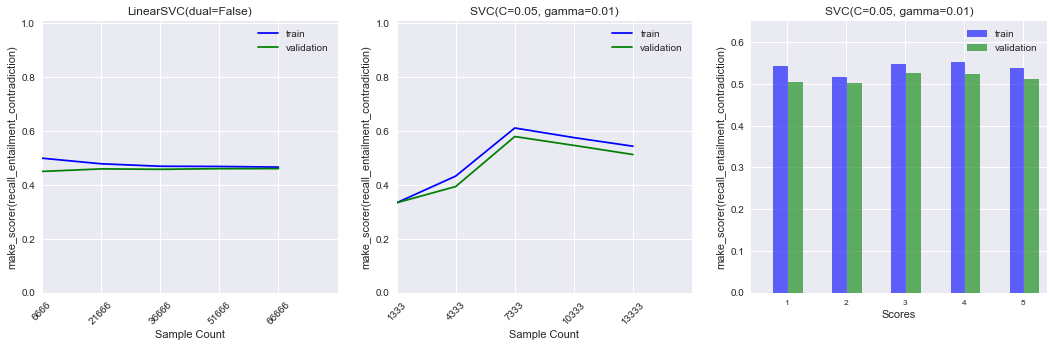

In [91]:
svm_untuned_learning_curve_plot = LearningCurvePlot(experiment=svm_untuned_learning_curve)
svm_tuned_learning_curve_plot = LearningCurvePlot(experiment=svm_tuned_learning_curve)

svm_learning_curves_fig, axs = plt.subplots(1, 3, figsize=(18, 5))
_, ax = svm_untuned_learning_curve_plot.plot(ax=axs[0], ymin=0.0, ymax=1.01)
_, ax = svm_tuned_learning_curve_plot.plot(ax=axs[1], ymin=0.0, ymax=1.01)
_, ax = svm_tuned_cv_folds.plot(ax=axs[2])

In [92]:
svm_learning_curves_fig.savefig(
    "../out/SNLI/SVM/LearningCurves - Report.png",
    bbox_inches='tight',
    dpi=800
)

In [32]:
linear_svc_val_curv = ValidationCurve(
    LinearSVC(C=1.0, max_iter=1000, penalty='l2', dual=False, verbose=0),
    'C', 
    [0.001, 0.01, 0.1, 1.0, 10],
    scoring=recall_scorer,
    n_splits=3
)
linear_svc_val_curv.run(X_train, y_train)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of  15 | elapsed:   17.8s remaining:   49.1s
[Parallel(n_jobs=3)]: Done   8 out of  15 | elapsed:   27.2s remaining:   23.8s
[Parallel(n_jobs=3)]: Done  12 out of  15 | elapsed:   37.1s remaining:    9.3s
[Parallel(n_jobs=3)]: Done  15 out of  15 | elapsed:   46.1s finished


True

In [33]:
svc_high_gamma_val_curv = ValidationCurve(
    SVC(gamma=0.01, kernel='rbf', verbose=0),
    'C', 
    np.arange(0.01, 4, 1.0),
    scoring=recall_scorer,
    n_splits=3
)
svc_high_gamma_val_curv.run(X_train_sub, y_train_sub)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of  12 | elapsed:  1.1min remaining: 11.9min


[CV] END ..................., score=(train=0.548, test=0.526) total time=  58.1s
[CV] END ..................., score=(train=0.551, test=0.523) total time=  45.9s
[CV] END .............C=0.1;, score=(train=0.468, test=0.467) total time=   9.7s
[CV] END ...........C=0.001;, score=(train=0.469, test=0.455) total time=   8.4s
[CV] END .............C=1.0;, score=(train=0.468, test=0.456) total time=   8.8s
[CV] END ...........C=0.001;, score=(train=0.463, test=0.460) total time=   8.7s
[CV] END .............C=0.1;, score=(train=0.463, test=0.460) total time=   8.7s
[CV] END ............C=0.01;, score=(train=0.500, test=0.500) total time=  45.6s
[CV] END ............C=0.01;, score=(train=0.522, test=0.524) total time=  38.3s


[Parallel(n_jobs=3)]: Done   4 out of  12 | elapsed:  2.2min remaining:  4.4min


[CV] END ..................., score=(train=0.537, test=0.512) total time=  45.9s
[CV] END ............C=0.01;, score=(train=0.468, test=0.466) total time=   9.2s
[CV] END ..............C=10;, score=(train=0.468, test=0.467) total time=   8.8s
[CV] END .............C=0.1;, score=(train=0.468, test=0.456) total time=   9.7s
[CV] END ............C=0.01;, score=(train=0.463, test=0.459) total time=   9.2s
[CV] END ..............C=10;, score=(train=0.463, test=0.459) total time=   9.0s
[CV] END ............C=2.01;, score=(train=0.922, test=0.481) total time=  52.2s
[CV] END ............C=1.01;, score=(train=0.818, test=0.530) total time=  34.7s


[Parallel(n_jobs=3)]: Done   7 out of  12 | elapsed:  3.3min remaining:  2.4min
[Parallel(n_jobs=3)]: Done  10 out of  12 | elapsed:  4.3min remaining:   51.3s


[CV] END ..................., score=(train=0.516, test=0.502) total time= 1.0min
[CV] END ...........C=0.001;, score=(train=0.469, test=0.466) total time=   8.3s
[CV] END .............C=1.0;, score=(train=0.468, test=0.467) total time=   9.4s
[CV] END ............C=0.01;, score=(train=0.469, test=0.456) total time=   9.2s
[CV] END ..............C=10;, score=(train=0.468, test=0.456) total time=   9.8s
[CV] END .............C=1.0;, score=(train=0.463, test=0.459) total time=   8.9s
[CV] END ............C=1.01;, score=(train=0.813, test=0.495) total time=  41.7s
[CV] END ............C=3.01;, score=(train=0.965, test=0.480) total time=  59.0s
[CV] END ............C=0.01;, score=(train=0.506, test=0.503) total time=  36.7s
[CV] END ............C=2.01;, score=(train=0.922, test=0.502) total time=  43.8s


[Parallel(n_jobs=3)]: Done  12 out of  12 | elapsed:  4.8min finished


True

In [34]:
svc_low_gamma_val_curv = ValidationCurve(
    SVC(gamma=0.0001, kernel='rbf', verbose=0),
    'C', 
    np.arange(0.01, 4, 1.0),
    scoring=recall_scorer,
    n_splits=3
)
svc_low_gamma_val_curv.run(X_train_sub, y_train_sub)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of  12 | elapsed:   59.5s remaining: 10.9min
[Parallel(n_jobs=3)]: Done   4 out of  12 | elapsed:  2.0min remaining:  3.9min


[CV] END ............C=2.01;, score=(train=0.928, test=0.504) total time=  45.7s
[CV] END ............C=1.01;, score=(train=0.822, test=0.516) total time=  33.9s
[CV] END ............C=0.01;, score=(train=0.000, test=0.000) total time=  38.2s
[CV] END ............C=1.01;, score=(train=0.457, test=0.442) total time=  37.0s
[CV] END ............C=3.01;, score=(train=0.965, test=0.492) total time=  58.0s
[CV] END ............C=3.01;, score=(train=0.963, test=0.496) total time=  55.2s
[CV] END ............C=1.01;, score=(train=0.449, test=0.431) total time=  36.8s
[CV] END ............C=3.01;, score=(train=0.477, test=0.449) total time=  35.3s
[CV] END ............C=2.01;, score=(train=0.480, test=0.465) total time=  35.0s


[Parallel(n_jobs=3)]: Done   7 out of  12 | elapsed:  2.9min remaining:  2.1min
[Parallel(n_jobs=3)]: Done  10 out of  12 | elapsed:  3.9min remaining:   46.7s
[Parallel(n_jobs=3)]: Done  12 out of  12 | elapsed:  4.0min finished


True

In [35]:
svc_gamma_val_curv = ValidationCurve(
    SVC(C=0.1, kernel='rbf', verbose=0),
    'gamma', 
    [0.001, 0.005, 0.01, 0.05, 0.1],
    scoring=recall_scorer,
    n_splits=3
)
svc_gamma_val_curv.run(X_train_sub, y_train_sub)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of  15 | elapsed:  1.9min remaining:  5.3min


[CV] END ............C=1.01;, score=(train=0.481, test=0.464) total time=  36.3s
[CV] END ........gamma=0.01;, score=(train=0.578, test=0.522) total time=  35.6s
[CV] END .........gamma=0.1;, score=(train=0.500, test=0.500) total time=  38.6s
[CV] END ............C=0.01;, score=(train=0.500, test=0.500) total time=  37.1s
[CV] END ............C=3.01;, score=(train=0.503, test=0.490) total time=  35.1s
[CV] END .......gamma=0.005;, score=(train=0.549, test=0.511) total time=  35.5s
[CV] END ........gamma=0.05;, score=(train=0.500, test=0.500) total time=  35.3s
[CV] END .......gamma=0.005;, score=(train=0.532, test=0.507) total time=  41.2s


[Parallel(n_jobs=3)]: Done   8 out of  15 | elapsed:  3.1min remaining:  2.7min
[Parallel(n_jobs=3)]: Done  12 out of  15 | elapsed:  4.2min remaining:  1.1min
[Parallel(n_jobs=3)]: Done  15 out of  15 | elapsed:  5.4min finished


True

In [36]:
svc_gamma_val_curv_plot = ValidationCurvePlot(experiment=svc_gamma_val_curv)
linear_svc_val_curv_plot = ValidationCurvePlot(experiment=linear_svc_val_curv)
svc_high_gamma_val_curv_plot = ValidationCurvePlot(experiment=svc_high_gamma_val_curv)
svc_low_gamma_val_curv_plot = ValidationCurvePlot(experiment=svc_low_gamma_val_curv)

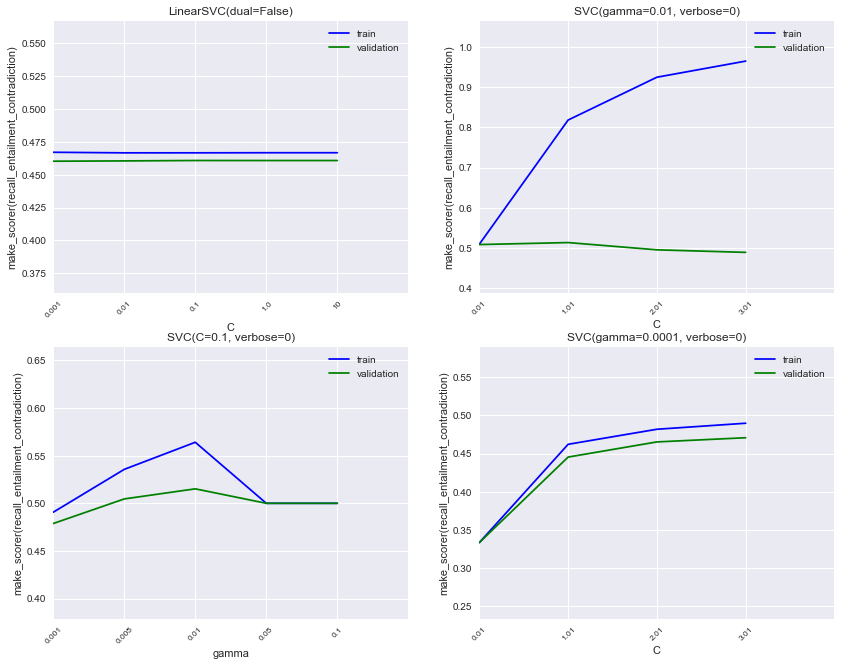

In [37]:
svc_val_curvs_fig, axs = plt.subplots(2, 2, figsize=(14, 11))
_, ax = linear_svc_val_curv_plot.plot(ax=axs[0][0])
_, ax = svc_high_gamma_val_curv_plot.plot(ax=axs[0][1])
_, ax = svc_gamma_val_curv_plot.plot(ax=axs[1][0])
_, ax = svc_low_gamma_val_curv_plot.plot(ax=axs[1][1])

In [38]:
svc_val_curvs_fig.savefig(
    "../out/SNLI/SVM/Validation Curves - Report.png",  
    bbox_inches='tight',
    dpi=800
)

In [39]:
tuned_model_eval = ModelEvaluation(tuned_svm_clf)
tuned_model_eval.run(X_train, y_train, snli_data.X_test, snli_data.y_test)
print(tuned_model_eval.model)
print(ClassificationReport(experiment=tuned_model_eval).plot())

[CV] END ............C=2.01;, score=(train=0.469, test=0.446) total time=  36.6s
[CV] END ............C=0.01;, score=(train=0.500, test=0.500) total time=  37.4s
[CV] END ............C=3.01;, score=(train=0.489, test=0.473) total time=  34.1s
[CV] END ............C=2.01;, score=(train=0.496, test=0.485) total time=  34.4s
[CV] END .......gamma=0.001;, score=(train=0.506, test=0.487) total time=  37.3s
[CV] END .......gamma=0.001;, score=(train=0.490, test=0.481) total time=  37.3s
[CV] END ........gamma=0.05;, score=(train=0.500, test=0.500) total time=  39.8s
[CV] END .......gamma=0.001;, score=(train=0.476, test=0.468) total time=  43.5s
[CV] END ........gamma=0.05;, score=(train=0.500, test=0.500) total time=  41.1s
[CV] END ........gamma=0.01;, score=(train=0.561, test=0.512) total time=  41.5s
[CV] END .......gamma=0.005;, score=(train=0.526, test=0.495) total time=  41.4s
[CV] END ........gamma=0.01;, score=(train=0.553, test=0.512) total time=  42.8s
[CV] END .........gamma=0.1;

## k-Nearest Neighbors

In [41]:
knn_untuned_clf = KNeighborsClassifier(n_neighbors=5, p=2, weights='uniform')
knn_tuned_clf = KNeighborsClassifier(n_neighbors=9, weights='uniform', p=2)

In [43]:
knn_tuned_cv = CrossValidation(knn_tuned_clf, scoring=recall_scorer, n_splits=3)
knn_tuned_cv.run(X_train, y_train)
knn_tuned_cv_folds = CrossValidationFolds(experiment=knn_tuned_cv)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will bec

In [44]:
knn_untuned_learning_curve = LearningCurve(knn_untuned_clf, scoring=recall_scorer, n_splits=3)
knn_untuned_learning_curve.run(X_train, y_train)
knn_untuned_learning_curve_plot = LearningCurvePlot(experiment=knn_untuned_learning_curve)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


[learning_curve] Training set sizes: [ 6666 21666 36666 51666 66666]


/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated,

/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated,

/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
[Parallel(n_jobs=3)]: Done  15 out of  15 | elapsed:  3.3min finished


In [45]:
knn_tuned_learning_curve = LearningCurve(knn_tuned_clf, scoring=recall_scorer, n_splits=3)
knn_tuned_learning_curve.run(X_train, y_train)
knn_tuned_learning_curve_plot = LearningCurvePlot(experiment=knn_tuned_learning_curve)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


[learning_curve] Training set sizes: [ 6666 21666 36666 51666 66666]


/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated,

/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated,

/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
[Parallel(n_jobs=3)]: Done  15 out of  15 | elapsed:  3.3min finished


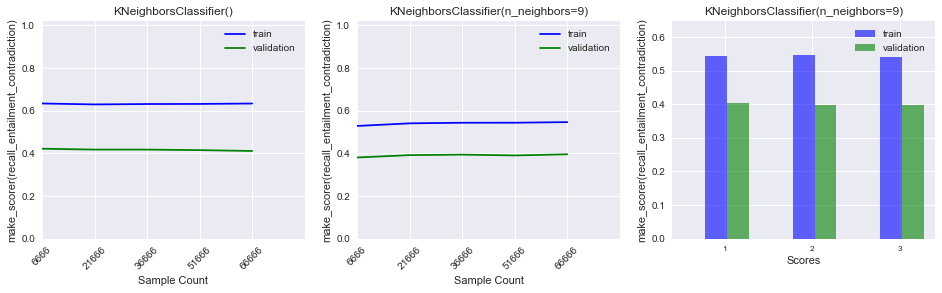

In [46]:
knn_train_curv_fig, axs = plt.subplots(1, 3, figsize=(16, 4))
_, ax = knn_untuned_learning_curve_plot.plot(ax=axs[0], ymin=0.0, ymax=1.02)
_, ax = knn_tuned_learning_curve_plot.plot(ax=axs[1], ymin=0.0, ymax=1.02)
_, ax = knn_tuned_cv_folds.plot(ax=axs[2])

In [47]:
knn_train_curv_fig.savefig(
    "../out/SNLI/KNN/Training Curves - Report.png",  
    bbox_inches='tight',
    dpi=800
)

In [52]:
distance_val_curv = ValidationCurve(
    KNeighborsClassifier(p=2, weights='distance', leaf_size=5000, algorithm='ball_tree'), 
    'n_neighbors', 
    [100, 5000, 10000],
    scoring=recall_scorer,
    n_splits=3
)
distance_val_curv.run(X_train_sub, y_train_sub)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   9 | elapsed:  1.2min remaining:  4.4min
[Parallel(n_jobs=3)]: Done   4 out of   9 | elapsed:  1.5min remaining:  1.9min
[Parallel(n_jobs=3)]: Done   6 out of   9 | elapsed:  2.5min remaining:  1.2min
[Parallel(n_jobs=3)]: Done   9 out of   9 | elapsed:  4.0min finished


True

In [53]:
uniform_val_curv = ValidationCurve(
    KNeighborsClassifier(p=1, weights='uniform'), 
    'n_neighbors', 
    np.arange(2, 120, 20),
    scoring=recall_scorer,
    n_splits=3
)
uniform_val_curv.run(X_train_sub, y_train_sub)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will bec

/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated,

/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated,

True

In [55]:
distance_val_curv_plot =  ValidationCurvePlot(experiment=distance_val_curv)
uniform_val_curv_plot =  ValidationCurvePlot(experiment=uniform_val_curv)

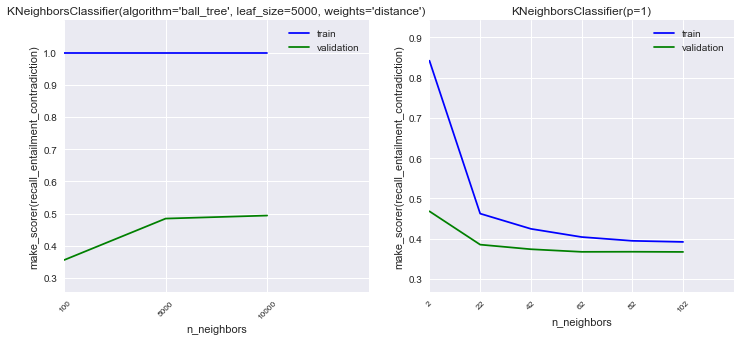

In [58]:
knn_val_curvs_fig, axs = plt.subplots(1, 2, figsize=(12, 5))
_, ax = distance_val_curv_plot.plot(ax=axs[0])
_, ax = uniform_val_curv_plot.plot(ax=axs[1])

In [59]:
knn_val_curvs_fig.savefig(
    "../out/SNLI/KNN/Validation Curves - Report.png",  
    bbox_inches='tight',
    dpi=800
)

In [60]:
knn_tuned_model_eval = ModelEvaluation(knn_tuned_clf)
knn_tuned_model_eval.run(X_train, y_train, snli_data.X_test, snli_data.y_test)
print(knn_tuned_model_eval.model)
print(ClassificationReport(experiment=knn_tuned_model_eval).plot())

KNeighborsClassifier(n_neighbors=9)
              precision    recall  f1-score   support

           0       0.40      0.49      0.44      3237
           1       0.47      0.33      0.39      3368
           2       0.39      0.42      0.40      3219

    accuracy                           0.41      9824
   macro avg       0.42      0.41      0.41      9824
weighted avg       0.42      0.41      0.41      9824



/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


## AdaBoost

In [61]:
dstump = DecisionTreeClassifier(max_depth=1)
ada_untuned_clf = AdaBoostClassifier(base_estimator=dstump, n_estimators=200, learning_rate=0.1)
weak_learner = DecisionTreeClassifier(max_depth=2)
ada_tuned_clf = AdaBoostClassifier(base_estimator=weak_learner, n_estimators=250, learning_rate=0.05)

In [62]:
ada_untuned_learning_curve = LearningCurve(ada_untuned_clf, scoring=recall_scorer, n_splits=3)
ada_untuned_learning_curve.run(X_train, y_train)
ada_untuned_learning_curve_plot = LearningCurvePlot(experiment=ada_untuned_learning_curve)

[learning_curve] Training set sizes: [ 6666 21666 36666 51666 66666]


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of  15 | elapsed:  2.4min remaining:  6.6min


[CV] END ..n_neighbors=5000;, score=(train=1.000, test=0.474) total time=  22.9s
[CV] END ..n_neighbors=5000;, score=(train=1.000, test=0.481) total time=  24.8s
[CV] END .n_neighbors=10000;, score=(train=1.000, test=0.500) total time=  37.9s
[CV] END ....n_neighbors=22;, score=(train=0.466, test=0.390) total time=   6.2s
[CV] END ....n_neighbors=62;, score=(train=0.402, test=0.366) total time=   6.1s
[CV] END .....n_neighbors=2;, score=(train=0.840, test=0.470) total time=   6.0s
[CV] END ....n_neighbors=62;, score=(train=0.407, test=0.373) total time=   6.6s
[CV] END ....n_neighbors=22;, score=(train=0.457, test=0.379) total time=   6.6s
[CV] END ....n_neighbors=82;, score=(train=0.395, test=0.360) total time=   6.2s
[CV] END ..................., score=(train=0.462, test=0.439) total time= 1.2min
[CV] END ..................., score=(train=0.475, test=0.465) total time= 3.8min


/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=3)]: Done   8 out of  15 | elapsed:  5.3min remaining:  4.6min
[Parallel(n_jobs=3)]: Done  12 out of  15 | elapsed:  8.5min remaining:  2.1min
[Parallel(n_jobs=3)]: Done  15 out of  15 | elapsed: 12.3min finished


In [63]:
ada_tuned_learning_curve = LearningCurve(ada_tuned_clf, scoring=recall_scorer, n_splits=3)
ada_tuned_learning_curve.run(X_train, y_train)
ada_tuned_learning_curve_plot = LearningCurvePlot(experiment=ada_tuned_learning_curve)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


[learning_curve] Training set sizes: [ 6666 21666 36666 51666 66666]


[Parallel(n_jobs=3)]: Done   4 out of  15 | elapsed:  5.7min remaining: 15.8min
[Parallel(n_jobs=3)]: Done   8 out of  15 | elapsed: 12.8min remaining: 11.2min
[Parallel(n_jobs=3)]: Done  12 out of  15 | elapsed: 20.3min remaining:  5.1min


[CV] END .n_neighbors=10000;, score=(train=1.000, test=0.493) total time=  27.6s
[CV] END ...n_neighbors=100;, score=(train=1.000, test=0.371) total time=  18.4s
[CV] END ..n_neighbors=5000;, score=(train=1.000, test=0.499) total time=  27.8s
[CV] END ....n_neighbors=42;, score=(train=0.430, test=0.371) total time=   6.2s
[CV] END ...n_neighbors=102;, score=(train=0.391, test=0.364) total time=   6.3s
[CV] END ....n_neighbors=22;, score=(train=0.465, test=0.387) total time=   5.9s
[CV] END ....n_neighbors=82;, score=(train=0.396, test=0.375) total time=   6.0s
[CV] END .....n_neighbors=2;, score=(train=0.844, test=0.462) total time=   5.8s
[CV] END ....n_neighbors=62;, score=(train=0.404, test=0.364) total time=   5.9s
[CV] END ..................., score=(train=0.469, test=0.411) total time=  20.4s
[CV] END ..................., score=(train=0.473, test=0.466) total time= 2.9min
[CV] END ..................., score=(train=0.462, test=0.446) total time= 2.0min
[CV] END ...................

[Parallel(n_jobs=3)]: Done  15 out of  15 | elapsed: 29.0min finished


In [66]:
ada_tuned_cv = CrossValidation(ada_tuned_clf, scoring=recall_scorer, n_splits=3)
ada_tuned_cv.run(X_train_samp, y_train_samp)
ada_tuned_cv_folds = CrossValidationFolds(experiment=ada_tuned_cv)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.6min finished


In [68]:
boost_iter = BoostingIterations(ada_tuned_clf, n_splits=3)
boost_iter.run(X_train_samp, y_train_samp)
boost_iter_plot = BoostingIterationsPlot(experiment=boost_iter)

/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


[CV] END ..................., score=(train=0.525, test=0.438) total time= 1.6min
[CV] END ..................., score=(train=0.542, test=0.462) total time= 1.6min
[CV] END ..................., score=(train=0.547, test=0.455) total time= 1.6min


/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


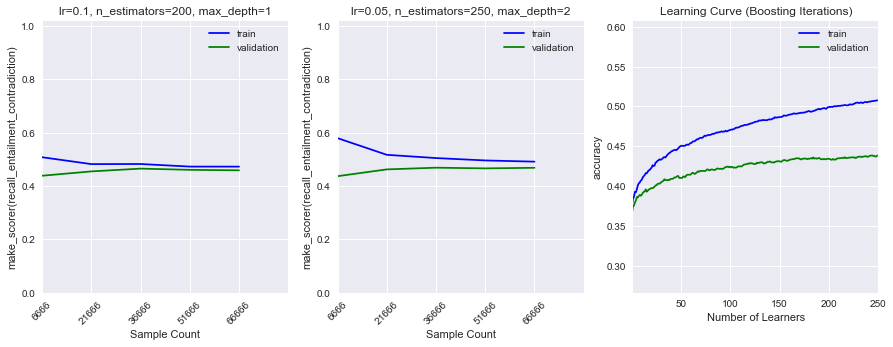

In [84]:
ada_train_curv_fig, axs = plt.subplots(1, 3, figsize=(15, 5))
_, ax = ada_untuned_learning_curve_plot.plot(ax=axs[0], ymin=0.0, ymax=1.02, title="lr=0.1, n_estimators=200, max_depth=1")
_, ax = ada_tuned_learning_curve_plot.plot(ax=axs[1], ymin=0.0, ymax=1.02, title="lr=0.05, n_estimators=250, max_depth=2")
# _, ax = ada_tuned_cv_folds.plot(title="Tuned model", ax=axs[1][0])
_, ax = boost_iter_plot.plot(ax=axs[2])

In [85]:
ada_train_curv_fig.savefig(
    "../out/SNLI/AdaBoost/Learning Curves - Report.png",  
    bbox_inches='tight',
    dpi=800
)

In [77]:
dt = DecisionTreeClassifier(max_depth=3)
ada_clf = AdaBoostClassifier(base_estimator=dt, learning_rate=0.1)

high_complexity_high_lr_curv = ValidationCurve(
    ada_clf,
    'n_estimators',
    np.arange(100, 500, 100),
    scoring=recall_scorer,
    n_splits=3
)
high_complexity_high_lr_curv.run(X_train_samp, y_train_samp)
high_complexity_high_lr_curv_plot = ValidationCurvePlot(experiment=high_complexity_high_lr_curv)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of  12 | elapsed:   27.5s remaining:  5.0min
[Parallel(n_jobs=3)]: Done   4 out of  12 | elapsed:  1.4min remaining:  2.7min
[Parallel(n_jobs=3)]: Done   7 out of  12 | elapsed:  2.7min remaining:  1.9min
[Parallel(n_jobs=3)]: Done  10 out of  12 | elapsed:  4.0min remaining:   48.3s
[Parallel(n_jobs=3)]: Done  12 out of  12 | elapsed:  5.3min finished


In [78]:
dt = DecisionTreeClassifier(max_depth=3)
ada_clf = AdaBoostClassifier(base_estimator=dt, learning_rate=0.01)

high_complexity_low_lr_curv = ValidationCurve(
    ada_clf,
    'n_estimators',
    np.arange(100, 500, 100),
    scoring=recall_scorer,
    n_splits=3
)
high_complexity_low_lr_curv.run(X_train_samp, y_train_samp)
high_complexity_low_lr_curv_plot = ValidationCurvePlot(experiment=high_complexity_low_lr_curv)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of  12 | elapsed:   26.5s remaining:  4.9min
[Parallel(n_jobs=3)]: Done   4 out of  12 | elapsed:  1.3min remaining:  2.7min
[Parallel(n_jobs=3)]: Done   7 out of  12 | elapsed:  2.7min remaining:  1.9min
[Parallel(n_jobs=3)]: Done  10 out of  12 | elapsed:  4.0min remaining:   47.8s
[Parallel(n_jobs=3)]: Done  12 out of  12 | elapsed:  5.3min finished


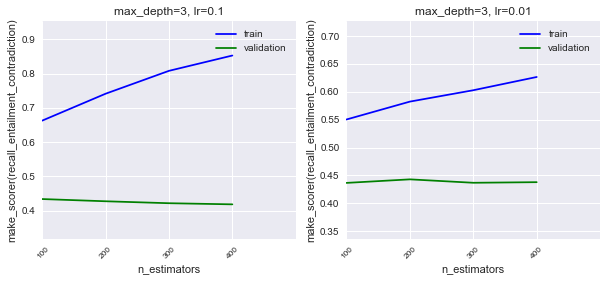

In [81]:
ada_val_curvs_fig, axs = plt.subplots(1, 2, figsize=(10, 4))
_, ax = high_complexity_high_lr_curv_plot.plot(ax=axs[0], title="max_depth=3, lr=0.1")
_, ax = high_complexity_low_lr_curv_plot.plot(ax=axs[1],  title="max_depth=3, lr=0.01")

In [82]:
ada_val_curvs_fig.savefig(
    "../out/SNLI/AdaBoost/Validation Curves - Report.png",  
    bbox_inches='tight',
    dpi=800
)

In [93]:
ada_tuned_model_eval = ModelEvaluation(ada_tuned_clf)
ada_tuned_model_eval.run(X_train, y_train, snli_data.X_test, snli_data.y_test)
print(ada_tuned_model_eval.model)
print(ClassificationReport(experiment=ada_tuned_model_eval).plot())

[CV] END ..................., score=(train=0.470, test=0.463) total time=   8.7s
[CV] END ..................., score=(train=0.471, test=0.457) total time=   4.7s
[CV] END ..................., score=(train=0.495, test=0.449) total time=   0.5s
[CV] END ..................., score=(train=0.477, test=0.463) total time=   2.3s
[CV] END ..................., score=(train=0.471, test=0.460) total time=   6.1s
[CV] END ..................., score=(train=0.469, test=0.458) total time=   4.6s
[CV] END ..................., score=(train=0.465, test=0.456) total time=   7.1s
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2),
                   learning_rate=0.05, n_estimators=250)
              precision    recall  f1-score   support

           0       0.44      0.46      0.45      3237
           1       0.49      0.48      0.49      3368
           2       0.41      0.40      0.41      3219

    accuracy                           0.45      9824
   macro avg       0.45      0.45

## Neural Network

In [105]:
nn_untuned_clf = NeuralNetworkClassifier(
    n_layers=2, 
    in_features=snli_data.X_train.shape[1], 
    out_features=150, 
    epochs=20,
    learning_rate=0.1,
    activation_fn=nn.ReLU,
    verbose=True
)
nn_tuned_clf = NeuralNetworkClassifier(
    n_layers=2, 
    in_features=snli_data.X_train.shape[1], 
    out_features=100, 
    epochs=60, 
    activation_fn=nn.ReLU,
    learning_rate=0.005,
    verbose=True
)

In [106]:
nn_untuned_learning_curve = LearningCurve(nn_untuned_clf, scoring=recall_scorer, n_splits=2)
nn_untuned_learning_curve.run(X_train_samp, y_train_samp)
nn_untuned_learning_curve_plot = LearningCurvePlot(experiment=nn_untuned_learning_curve)

[learning_curve] Training set sizes: [ 500 1625 2750 3875 5000]
Epoch:  0  -  4.952469825744629


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch:  1  -  4.793807029724121
Epoch:  2  -  4.585097312927246
Epoch:  3  -  4.336054801940918
Epoch:  4  -  4.054502010345459
Epoch:  5  -  3.7601211071014404
Epoch:  6  -  3.4649789333343506
Epoch:  7  -  3.1737425327301025
Epoch:  8  -  2.892298936843872
Epoch:  9  -  2.6278083324432373
Epoch:  10  -  2.3862342834472656
Epoch:  11  -  2.1713340282440186
Epoch:  12  -  1.9850056171417236
Epoch:  13  -  1.8271809816360474
Epoch:  14  -  1.696395754814148
Epoch:  15  -  1.589574933052063
Epoch:  16  -  1.502877950668335
Epoch:  17  -  1.4323514699935913
Epoch:  18  -  1.3744285106658936
Epoch:  19  -  1.3262830972671509
[CV] END ..................., score=(train=0.500, test=0.365) total time=   2.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


Epoch:  0  -  4.876068115234375
Epoch:  1  -  4.449180603027344
Epoch:  2  -  3.8928152322769165
Epoch:  3  -  3.295324206352234
Epoch:  4  -  2.7360652685165405
Epoch:  5  -  2.2587130069732666
Epoch:  6  -  1.8952571749687195
Epoch:  7  -  1.6470291018486023
Epoch:  8  -  1.487000584602356
Epoch:  9  -  1.382853388786316
Epoch:  10  -  1.312053382396698
Epoch:  11  -  1.2615253925323486
Epoch:  12  -  1.223901391029358
Epoch:  13  -  1.1948678493499756
Epoch:  14  -  1.1717456579208374
Epoch:  15  -  1.1528441905975342
Epoch:  16  -  1.1370379328727722
Epoch:  17  -  1.1235562562942505
Epoch:  18  -  1.1118456721305847
Epoch:  19  -  1.1015242338180542
[CV] END ..................., score=(train=0.465, test=0.385) total time=   6.4s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.4s remaining:    0.0s


Epoch:  0  -  4.99212630589803
Epoch:  1  -  4.471177895863851
Epoch:  2  -  3.655573050181071
Epoch:  3  -  2.825925827026367
Epoch:  4  -  2.1523368755976358
Epoch:  5  -  1.7201334238052368
Epoch:  6  -  1.4852771361668904
Epoch:  7  -  1.3575608730316162
Epoch:  8  -  1.281686504681905
Epoch:  9  -  1.2325118780136108
Epoch:  10  -  1.1983320713043213
Epoch:  11  -  1.173193057378133
Epoch:  12  -  1.1538476943969727
Epoch:  13  -  1.1384087800979614
Epoch:  14  -  1.1257172425587971
Epoch:  15  -  1.1150242884953816
Epoch:  16  -  1.1058200597763062
Epoch:  17  -  1.097753683725993
Epoch:  18  -  1.0905770858128865
Epoch:  19  -  1.0841015577316284
[CV] END ..................., score=(train=0.458, test=0.399) total time=  10.6s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   19.1s remaining:    0.0s


Epoch:  0  -  4.474903583526611
Epoch:  1  -  3.3339757919311523
Epoch:  2  -  2.3263211250305176
Epoch:  3  -  1.713579684495926
Epoch:  4  -  1.434523493051529
Epoch:  5  -  1.3044184148311615
Epoch:  6  -  1.2348544895648956
Epoch:  7  -  1.1927222311496735
Epoch:  8  -  1.1645529568195343
Epoch:  9  -  1.144244521856308
Epoch:  10  -  1.128758430480957
Epoch:  11  -  1.1164118945598602
Epoch:  12  -  1.1062188148498535
Epoch:  13  -  1.0975653529167175
Epoch:  14  -  1.0900492370128632
Epoch:  15  -  1.083390325307846
Epoch:  16  -  1.0774009227752686
Epoch:  17  -  1.071947306394577
Epoch:  18  -  1.0669149458408356
Epoch:  19  -  1.0622230470180511
[CV] END ..................., score=(train=0.480, test=0.412) total time=  15.0s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   34.1s remaining:    0.0s


Epoch:  0  -  4.5144853591918945
Epoch:  1  -  3.1279907703399656
Epoch:  2  -  2.0228899002075194
Epoch:  3  -  1.51316978931427
Epoch:  4  -  1.3219937801361084
Epoch:  5  -  1.2358935594558715
Epoch:  6  -  1.1888359308242797
Epoch:  7  -  1.1594043970108032
Epoch:  8  -  1.1391714096069336
Epoch:  9  -  1.1242658376693726
Epoch:  10  -  1.1126976251602172
Epoch:  11  -  1.103337335586548
Epoch:  12  -  1.095511293411255
Epoch:  13  -  1.0887903213500976
Epoch:  14  -  1.0828903436660766
Epoch:  15  -  1.0776154279708863
Epoch:  16  -  1.0728276014328002
Epoch:  17  -  1.0684224605560302
Epoch:  18  -  1.0643295764923095
Epoch:  19  -  1.0604890823364257
[CV] END ..................., score=(train=0.481, test=0.435) total time=  19.6s
Epoch:  0  -  4.99157190322876
Epoch:  1  -  4.837656021118164
Epoch:  2  -  4.633539199829102
Epoch:  3  -  4.417027950286865
Epoch:  4  -  4.192920684814453
Epoch:  5  -  3.956191062927246
Epoch:  6  -  3.699596643447876
Epoch:  7  -  3.42566919326782

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.8min finished


In [107]:
nn_tuned_learning_curve = LearningCurve(nn_tuned_clf, scoring=recall_scorer, n_splits=2)
nn_tuned_learning_curve.run(X_train_samp, y_train_samp)
nn_tuned_learning_curve_plot = LearningCurvePlot(experiment=nn_tuned_learning_curve)

[learning_curve] Training set sizes: [ 500 1625 2750 3875 5000]
Epoch:  0  -  4.5302629470825195


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch:  1  -  4.5224995613098145
Epoch:  2  -  4.514377593994141
Epoch:  3  -  4.506169319152832
Epoch:  4  -  4.497838020324707
Epoch:  5  -  4.489306449890137
Epoch:  6  -  4.480559825897217
Epoch:  7  -  4.471601963043213
Epoch:  8  -  4.46239709854126
Epoch:  9  -  4.4530205726623535
Epoch:  10  -  4.443531036376953
Epoch:  11  -  4.433905601501465
Epoch:  12  -  4.424052715301514
Epoch:  13  -  4.413979530334473
Epoch:  14  -  4.403835296630859
Epoch:  15  -  4.393557071685791
Epoch:  16  -  4.3832244873046875
Epoch:  17  -  4.372827053070068
Epoch:  18  -  4.362372875213623
Epoch:  19  -  4.351860523223877
Epoch:  20  -  4.341257095336914
Epoch:  21  -  4.330597877502441
Epoch:  22  -  4.319886207580566
Epoch:  23  -  4.309175968170166
Epoch:  24  -  4.298468112945557
Epoch:  25  -  4.287757873535156
Epoch:  26  -  4.277010440826416
Epoch:  27  -  4.266263008117676
Epoch:  28  -  4.255517959594727
Epoch:  29  -  4.2447710037231445
Epoch:  30  -  4.234007835388184
Epoch:  31  -  4

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.9s remaining:    0.0s


Epoch:  0  -  4.553414583206177
Epoch:  1  -  4.543675899505615
Epoch:  2  -  4.533825159072876
Epoch:  3  -  4.523893117904663
Epoch:  4  -  4.513822317123413
Epoch:  5  -  4.5036094188690186
Epoch:  6  -  4.4932544231414795
Epoch:  7  -  4.482735633850098
Epoch:  8  -  4.472038507461548
Epoch:  9  -  4.461159706115723
Epoch:  10  -  4.450084209442139
Epoch:  11  -  4.438854217529297
Epoch:  12  -  4.427480697631836
Epoch:  13  -  4.4159324169158936
Epoch:  14  -  4.404190301895142
Epoch:  15  -  4.392226696014404
Epoch:  16  -  4.380021095275879
Epoch:  17  -  4.367528676986694
Epoch:  18  -  4.354682445526123
Epoch:  19  -  4.341418266296387
Epoch:  20  -  4.327712059020996
Epoch:  21  -  4.313671112060547
Epoch:  22  -  4.2991554737091064
Epoch:  23  -  4.284153938293457
Epoch:  24  -  4.2687153816223145
Epoch:  25  -  4.252825498580933
Epoch:  26  -  4.236582517623901
Epoch:  27  -  4.219838619232178
Epoch:  28  -  4.202637195587158
Epoch:  29  -  4.185030698776245
Epoch:  30  -  

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   24.9s remaining:    0.0s


Epoch:  0  -  4.525331338246663
Epoch:  1  -  4.505356470743815
Epoch:  2  -  4.484132607777913
Epoch:  3  -  4.461326599121094
Epoch:  4  -  4.436793804168701
Epoch:  5  -  4.411100546518962
Epoch:  6  -  4.3843685785929365
Epoch:  7  -  4.356569608052571
Epoch:  8  -  4.3277608553568525
Epoch:  9  -  4.298142115275065
Epoch:  10  -  4.267943064371745
Epoch:  11  -  4.237196922302246
Epoch:  12  -  4.206226507822673
Epoch:  13  -  4.175048828125
Epoch:  14  -  4.143757502237956
Epoch:  15  -  4.112385590871175
Epoch:  16  -  4.08098824818929
Epoch:  17  -  4.049564679463704
Epoch:  18  -  4.018125534057617
Epoch:  19  -  3.9866742293039956
Epoch:  20  -  3.9552060763041177
Epoch:  21  -  3.9237187703450522
Epoch:  22  -  3.892210324605306
Epoch:  23  -  3.8606786727905273
Epoch:  24  -  3.8291216691335044
Epoch:  25  -  3.797536611557007
Epoch:  26  -  3.7659226258595786
Epoch:  27  -  3.7342780431111655
Epoch:  28  -  3.70259960492452
Epoch:  29  -  3.670886437098185
Epoch:  30  -  3

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   56.9s remaining:    0.0s


Epoch:  0  -  4.671107530593872
Epoch:  1  -  4.664677143096924
Epoch:  2  -  4.657184839248657
Epoch:  3  -  4.6485971212387085
Epoch:  4  -  4.6390005350112915
Epoch:  5  -  4.628251075744629
Epoch:  6  -  4.616339802742004
Epoch:  7  -  4.603329300880432
Epoch:  8  -  4.589356184005737
Epoch:  9  -  4.5745192766189575
Epoch:  10  -  4.5588250160217285
Epoch:  11  -  4.542405009269714
Epoch:  12  -  4.525373816490173
Epoch:  13  -  4.5076552629470825
Epoch:  14  -  4.489138245582581
Epoch:  15  -  4.469740390777588
Epoch:  16  -  4.449470281600952
Epoch:  17  -  4.428271532058716
Epoch:  18  -  4.406293272972107
Epoch:  19  -  4.383622527122498
Epoch:  20  -  4.3601309061050415
Epoch:  21  -  4.335896730422974
Epoch:  22  -  4.3110140562057495
Epoch:  23  -  4.2853052616119385
Epoch:  24  -  4.258834600448608
Epoch:  25  -  4.2316343784332275
Epoch:  26  -  4.203784346580505
Epoch:  27  -  4.175359129905701
Epoch:  28  -  4.146329641342163
Epoch:  29  -  4.116648197174072
Epoch:  30 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.7min remaining:    0.0s


Epoch:  0  -  4.537473869323731
Epoch:  1  -  4.504115295410156
Epoch:  2  -  4.467199993133545
Epoch:  3  -  4.427042770385742
Epoch:  4  -  4.384147262573242
Epoch:  5  -  4.339005184173584
Epoch:  6  -  4.2919995307922365
Epoch:  7  -  4.243763732910156
Epoch:  8  -  4.194775676727295
Epoch:  9  -  4.145406436920166
Epoch:  10  -  4.095842075347901
Epoch:  11  -  4.0461383819580075
Epoch:  12  -  3.9963522434234617
Epoch:  13  -  3.9465098857879637
Epoch:  14  -  3.8965975284576415
Epoch:  15  -  3.8466138362884523
Epoch:  16  -  3.796550989151001
Epoch:  17  -  3.7464061737060548
Epoch:  18  -  3.6961765766143797
Epoch:  19  -  3.645859432220459
Epoch:  20  -  3.59545693397522
Epoch:  21  -  3.544970893859863
Epoch:  22  -  3.4944053649902345
Epoch:  23  -  3.4437742710113524
Epoch:  24  -  3.3930914402008057
Epoch:  25  -  3.3423718452453612
Epoch:  26  -  3.2916354179382323
Epoch:  27  -  3.2409063816070556
Epoch:  28  -  3.1902120113372803
Epoch:  29  -  3.1395827770233153
Epoch

Epoch:  0  -  4.641348361968994
Epoch:  1  -  4.630952000617981
Epoch:  2  -  4.618720769882202
Epoch:  3  -  4.60448944568634
Epoch:  4  -  4.587950706481934
Epoch:  5  -  4.5687302350997925
Epoch:  6  -  4.546473503112793
Epoch:  7  -  4.521279692649841
Epoch:  8  -  4.493125796318054
Epoch:  9  -  4.462422728538513
Epoch:  10  -  4.4294246435165405
Epoch:  11  -  4.39439070224762
Epoch:  12  -  4.357560634613037
Epoch:  13  -  4.319117546081543
Epoch:  14  -  4.2797611951828
Epoch:  15  -  4.239765167236328
Epoch:  16  -  4.199310660362244
Epoch:  17  -  4.158554673194885
Epoch:  18  -  4.117483973503113
Epoch:  19  -  4.07624351978302
Epoch:  20  -  4.034879207611084
Epoch:  21  -  3.9934072494506836
Epoch:  22  -  3.9518184661865234
Epoch:  23  -  3.910145938396454
Epoch:  24  -  3.8683988451957703
Epoch:  25  -  3.826575756072998
Epoch:  26  -  3.784671127796173
Epoch:  27  -  3.742685079574585
Epoch:  28  -  3.7006208896636963
Epoch:  29  -  3.6584801077842712
Epoch:  30  -  3.6

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  5.3min finished


In [ ]:
nn_tuned_cv = CrossValidation(nn_tuned_clf, scoring=recall_scorer, n_splits=3)
nn_tuned_cv.run(X_train_samp, y_train_samp)
nn_tuned_cv_folds = CrossValidationFolds(experiment=nn_tuned_cv)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch:  0  -  4.608843530927386
Epoch:  1  -  4.573557104383196
Epoch:  2  -  4.531754629952567
Epoch:  3  -  4.485419477735247
Epoch:  4  -  4.436138766152518
Epoch:  5  -  4.384839807237897
Epoch:  6  -  4.332160949707031
Epoch:  7  -  4.278037888663156
Epoch:  8  -  4.222313472202846
Epoch:  9  -  4.164631230490548
Epoch:  10  -  4.104531901223319
Epoch:  11  -  4.041524274008615
Epoch:  12  -  3.9754758221762523
Epoch:  13  -  3.9065960475376675
Epoch:  14  -  3.835500921521868
Epoch:  15  -  3.762664658682687
Epoch:  16  -  3.6887220314570834
Epoch:  17  -  3.613925422940935
Epoch:  18  -  3.538696357182094
Epoch:  19  -  3.463353259222848
Epoch:  20  -  3.388050522123064
Epoch:  21  -  3.3128821849823
Epoch:  22  -  3.237940175192697
Epoch:  23  -  3.1633289882114957
Epoch:  24  -  3.089163030896868
Epoch:  25  -  3.015575477055141
Epoch:  26  -  2.942694459642683
Epoch:  27  -  2.870666469846453
Epoch:  28  -  2.799644776753017
Epoch:  29  -  2.7297758034297397
Epoch:  30  -  2.

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s


Epoch:  0  -  4.691572325570243
Epoch:  1  -  4.688056128365653
Epoch:  2  -  4.683796746390207
Epoch:  3  -  4.678586823599679
Epoch:  4  -  4.672211919512067
Epoch:  5  -  4.66446624483381
Epoch:  6  -  4.654956749507359
Epoch:  7  -  4.6431194714137485
Epoch:  8  -  4.628230844225202
Epoch:  9  -  4.6102617127554755
Epoch:  10  -  4.589081832340786
Epoch:  11  -  4.564395836421421
Epoch:  12  -  4.535942077636719
Epoch:  13  -  4.503895078386579
Epoch:  14  -  4.468145029885428
Epoch:  15  -  4.4284612110682895
Epoch:  16  -  4.384748458862305
Epoch:  17  -  4.33709716796875
Epoch:  18  -  4.286117826189313
Epoch:  19  -  4.232200963156564
Epoch:  20  -  4.175571850367954
Epoch:  21  -  4.11670936856951
Epoch:  22  -  4.055778094700405
Epoch:  23  -  3.9927052429744174
Epoch:  24  -  3.927405527659825
Epoch:  25  -  3.859917095729283
Epoch:  26  -  3.790203196661813
Epoch:  27  -  3.7184485026768277
Epoch:  28  -  3.6447841780526296
Epoch:  29  -  3.5696707453046526
Epoch:  30  -  3

In [ ]:
nn_clf = NeuralNetworkClassifier(
    epochs=100, 
    n_layers=2, 
    out_features=600,
    learning_rate=0.00009,
    in_features=X_train.shape[1],
    activation_fn=nn.ReLU,
    verbose=True
) 
tuned_learning_curve_epochs = LearningCurveEpochs(
    nn_clf, 
    scoring='cross-entropy', 
    n_splits=3
)
tuned_learning_curve_epochs.run(X_train_samp, y_train_samp)
tuned_learning_curve_epochs_plot = LearningEpochsCurvePlot(experiment=tuned_learning_curve_epochs)

In [ ]:
nn_train_curv_fig, axs = plt.subplots(1, 3, figsize=(16, 4))
_, ax = nn_untuned_learning_curve_plot.plot(ax=axs[0], ymin=0.0, ymax=1.02)
_, ax = nn_tuned_learning_curve_plot.plot(ax=axs[1], ymin=0.0, ymax=1.02)
# _, ax = nn_tuned_cv_folds.plot(ax=axs[2])
_, ax = tuned_learning_curve_epochs_plot.plot(ax=axs[2])

In [ ]:
nn_train_curv_fig.savefig(
    "../out/SNLI/NeuralNetwork/Learning Curves - Report.png",  
    bbox_inches='tight',
    dpi=800
)

In [ ]:
nn_nodes_val_curv = ValidationCurve(
    NeuralNetworkClassifier(
        epochs=60, 
        n_layers=2, 
        learning_rate=0.001,
        in_features=X_train.shape[1],
        activation_fn=nn.ReLU,
        verbose=True
    ), 
    'out_features', 
    [25, 50, 100, 200],
    scoring=recall_scorer,
    n_splits=2
)
nn_nodes_val_curv.run(X_train_samp, y_train_samp)
nn_nodes_val_curv_plot = ValidationCurvePlot(experiment=nn_nodes_val_curv)

In [ ]:
nn_lr_val_curv = ValidationCurve(
    NeuralNetworkClassifier(
        epochs=40, 
        n_layers=2, 
        in_features=X_train.shape[1],
        activation_fn=nn.ReLU,
        out_features=100,
        verbose=True
    ), 
    'learning_rate', 
    [0.0001, 0.001, 0.01, 0.1],
    scoring=recall_scorer,
    n_splits=2
)
nn_lr_val_curv.run(X_train_samp, y_train_samp)
nn_lr_val_curv_plot = ValidationCurvePlot(experiment=nn_lr_val_curv)

In [ ]:
nn_val_curvs_fig, axs = plt.subplots(1, 2, figsize=(10, 4))
_, ax = nn_nodes_val_curv_plot.plot(ax=axs[0])
_, ax = nn_lr_val_curv_plot.plot(ax=axs[1])

In [ ]:
nn_val_curvs_fig.savefig(
    "../out/SNLI/NeuralNetwork/Validation Curves - Report.png",  
    bbox_inches='tight',
    dpi=800
)

In [98]:
nn_tuned_model_eval = ModelEvaluation(nn_tuned_clf)
nn_tuned_model_eval.run(X_train[:10000], y_train[:10000], snli_data.X_test, snli_data.y_test)
print(nn_tuned_model_eval.model)
print(ClassificationReport(experiment=nn_tuned_model_eval).plot())

Epoch:  0  -  4.620053243637085
Epoch:  1  -  4.57956166267395
Epoch:  2  -  4.521323919296265
Epoch:  3  -  4.444879579544067
Epoch:  4  -  4.355063724517822
Epoch:  5  -  4.259822368621826
Epoch:  6  -  4.162961626052857
Epoch:  7  -  4.0656801700592045
Epoch:  8  -  3.9680662870407106
Epoch:  9  -  3.870047450065613
NeuralNetworkClassifier(epochs=10, in_features=150, learning_rate=0.005,
                        verbose=True)
              precision    recall  f1-score   support

           0       0.33      0.12      0.17      3237
           1       0.36      0.50      0.42      3368
           2       0.34      0.41      0.37      3219
          49       0.00      0.00      0.00         0
          83       0.00      0.00      0.00         0

    accuracy                           0.34      9824
   macro avg       0.20      0.21      0.19      9824
weighted avg       0.34      0.34      0.32      9824



/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

## Compare Wall Clock Times

In [101]:
compare_fit_scores_times_plot = CompareFitScoreTimes(experiments=[
    dt_tuned_learning_curve, 
    svm_tuned_learning_curve, 
    knn_tuned_learning_curve,
    ada_tuned_learning_curve,
    nn_tuned_learning_curve
])

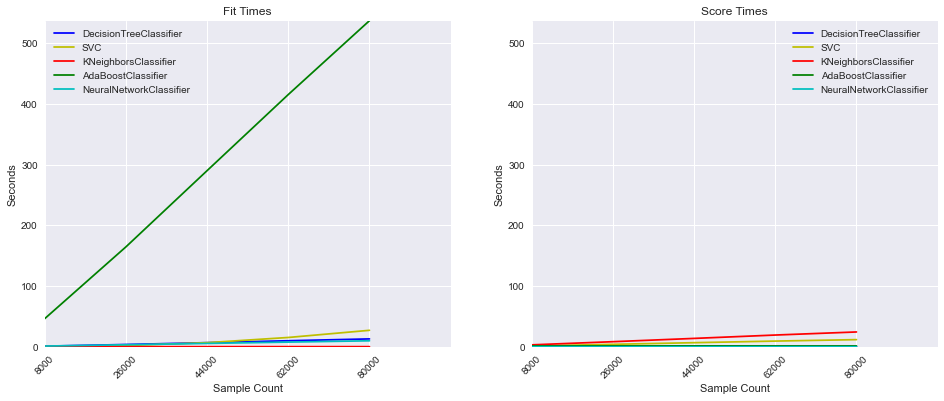

In [102]:
compare_fit_scores_times_fig, ax = compare_fit_scores_times_plot.plot(figsize=(16, 6))

In [104]:
compare_fit_scores_times_fig.savefig(
    "../out/SNLI/Compare Fit and Times - Report.png",  
    bbox_inches='tight',
    dpi=800
)